In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats

In [2]:
df = pd.read_feather("measurements.feather")
df = df.dropna(subset=["Has Consent Dialog?", "Has Ads?"])
df

,ID,URL,Has Consent Dialog?,Has Ads?,Comment,Consent Strategy,Operating System,Browser,Browser Profile,Language,location
0,1,https://www.windowspro.de,yes,generic,<NA>,accept,Windows,Chrome,existing,de,in class
1,1,https://www.boerse-online.de,yes,personalized,<NA>,accept,Windows,Chrome,existing,de,in class
2,1,https://www.bildderfrau.de,yes,generic,<NA>,accept,Windows,Chrome,existing,de,in class
3,1,https://www.stylebook.de,yes,no,<NA>,accept,Windows,Chrome,existing,de,in class
4,1,https://www.svz.de,yes,generic,<NA>,accept,Windows,Chrome,existing,de,in class
...,...,...,...,...,...,...,...,...,...,...,...
3345,67,https://www.news.de,no,no,<NA>,reject simple,Windows,Edge,existing,en,from home (repeated)
3346,67,https://efahrer.chip.de,yes,generic,<NA>,reject simple,Windows,Edge,existing,en,from home (repeated)
3347,67,https://www.zeit.de/,no,no,<NA>,reject simple,Windows,Edge,existing,en,from home (repeated)
3348,67,https://www.harpersbazaar.de/,yes,no,<NA>,reject simple,Windows,Edge,existing,en,from home (repeated)


In [3]:
df.groupby("ID").first().location.value_counts()

from home               27
from home (repeated)    23
in class                17
Name: location, dtype: int64

In [4]:
df.groupby("ID").first()["Browser Profile"].value_counts()


existing     51
new          11
incognito     5
Name: Browser Profile, dtype: int64

In [5]:
df.groupby("ID").first()["Language"].value_counts()


de    55
en    12
Name: Language, dtype: int64

In [6]:
df[["URL", "Consent Strategy"]].value_counts().value_counts()

5     313
1     263
4     189
3     113
2      89
6      11
10      1
dtype: int64

In [7]:
aggs = pd.concat([
    df.groupby("ID")["Has Ads?"].value_counts(normalize=True).unstack().add_prefix("has_ads_"),
    df.groupby("ID")["Has Consent Dialog?"].value_counts(normalize=True).unstack()["yes"],
    df[["ID", "Consent Strategy", "Operating System", "Browser", "Browser Profile", "Language", "location"]].groupby("ID").agg(pd.Series.mode)
], axis=1).fillna(0)
aggs

,has_ads_no,has_ads_generic,has_ads_personalized,yes,Consent Strategy,Operating System,Browser,Browser Profile,Language,location
ID,,,,,,,,,,
1,0.209302,0.418605,0.372093,0.976744,accept,Windows,Chrome,existing,de,in class
2,0.720000,0.280000,0.000000,0.900000,reject all,Windows,Chrome,existing,de,in class
3,0.240000,0.160000,0.600000,0.860000,accept,Windows,Chrome,existing,de,in class
4,0.681818,0.318182,0.000000,0.909091,reject all,Linux,Firefox,existing,en,in class
5,0.260000,0.700000,0.040000,0.980000,accept,Windows,Chrome,new,de,in class
...,...,...,...,...,...,...,...,...,...,...
63,0.666667,0.270833,0.062500,0.937500,reject simple,Windows,Chrome,existing,de,from home (repeated)
64,0.326531,0.551020,0.122449,0.959184,reject simple,Mac,Chrome,existing,de,from home (repeated)
65,0.632653,0.204082,0.163265,1.000000,reject simple,Windows,Chrome,new,de,from home (repeated)


In [8]:
a = aggs[aggs["Consent Strategy"] == "accept"]["has_ads_no"]
b = aggs[aggs["Consent Strategy"] == "reject simple"]["has_ads_no"]
scipy.stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=48.5, pvalue=0.0009274879783411893)

In [9]:
aggs[aggs["Consent Strategy"] == "reject simple"]["has_ads_personalized"].mean()

0.05629905808477236

In [31]:
aggs[aggs["Consent Strategy"] == "reject simple"][["has_ads_no","has_ads_generic","has_ads_personalized"]].mean()

has_ads_no              0.512632
has_ads_generic         0.431069
has_ads_personalized    0.056299
dtype: float64

In [32]:
aggs[aggs["Consent Strategy"] == "reject all"][["has_ads_no","has_ads_generic","has_ads_personalized"]].mean()

has_ads_no              0.668779
has_ads_generic         0.304769
has_ads_personalized    0.026452
dtype: float64

In [12]:
a = aggs[aggs["Consent Strategy"] == "reject simple"]["has_ads_no"]
b = aggs[aggs["Consent Strategy"] == "reject all"]["has_ads_no"]
scipy.stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=78.0, pvalue=0.0015537660351066169)

In [13]:
a = aggs[(aggs["location"] == "in class") & aggs["Consent Strategy"].isin(["reject all"])]["has_ads_no"]
b = aggs[(aggs["location"] != "in class") & aggs["Consent Strategy"].isin(["reject all"])]["has_ads_no"]
scipy.stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=116.0, pvalue=0.2886379661407319)

In [14]:
aggs[aggs["Consent Strategy"] == "accept"].groupby("location").has_ads_personalized.describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
from home,8.0,0.236582,0.273831,0.00,0.015,0.13,0.398163,0.66
from home (repeated),6.0,0.275034,0.239184,0.02,0.065,0.26,0.462653,0.58
in class,9.0,0.155539,0.224821,0.00,0.000,0.04,0.346939,0.60


In [33]:
def Chisq(table):
    tval, pval, dof = scipy.stats.chi2_contingency(table)[:3]
    pval = f"={pval:.2f}"
    if pval == "=0.00":
        pval = "<0.01"
    return fr"$\chi^2({dof}, N={table.sum().sum()}) = {tval:.2f}, p{pval}$"


print(Chisq(
    aggs[aggs["Consent Strategy"] == "reject all"][["has_ads_no", "has_ads_personalized", "has_ads_generic"]].applymap(lambda x: int(x*50))
))

$\chi^2(60, N=1529) = 239.76, p<0.01$


In [16]:
group = "reject all"
a = aggs[aggs["Consent Strategy"] == group]["has_ads_generic"] + aggs[aggs["Consent Strategy"] == group]["has_ads_personalized"]
b = aggs[aggs["Consent Strategy"] == group]["has_ads_no"]
a = a.apply(lambda x: int(x*50))
b = b.apply(lambda x: int(x*50))
print(Chisq(
    pd.concat([a,b], axis=1)
))

$\chi^2(30, N=1530) = 115.79, p<0.01$


In [17]:
#scipy.stats.kruskal(
#*[
#    list(col)
#    for n, col in
#aggs[aggs["Consent Strategy"] == "reject all"][["has_ads_no", "has_ads_generic"]].applymap(lambda x: int(x*50)).iteritems()
#])

reject all       31
accept           23
reject simple    13
Name: Consent Strategy, dtype: int64
reject all       0.462687
accept           0.343284
reject simple    0.194030
Name: Consent Strategy, dtype: float64


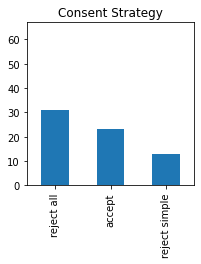

Windows    47
Linux      11
Mac         9
Name: Operating System, dtype: int64
Windows    0.701493
Linux      0.164179
Mac        0.134328
Name: Operating System, dtype: float64


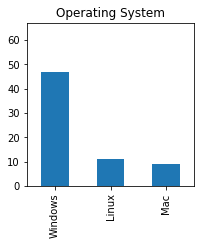

Chrome      37
Firefox     16
Edge         9
Safari       4
Chromium     1
Name: Browser, dtype: int64
Chrome      0.552239
Firefox     0.238806
Edge        0.134328
Safari      0.059701
Chromium    0.014925
Name: Browser, dtype: float64


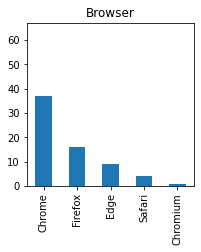

existing     51
new          11
incognito     5
Name: Browser Profile, dtype: int64
existing     0.761194
new          0.164179
incognito    0.074627
Name: Browser Profile, dtype: float64


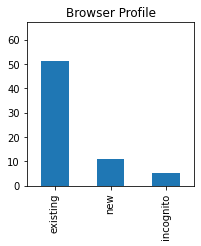

de    55
en    12
Name: Language, dtype: int64
de    0.820896
en    0.179104
Name: Language, dtype: float64


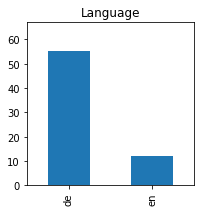

from home               27
from home (repeated)    23
in class                17
Name: location, dtype: int64
from home               0.402985
from home (repeated)    0.343284
in class                0.253731
Name: location, dtype: float64


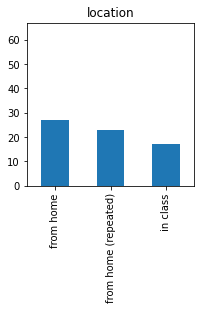

In [18]:
for col in ["Consent Strategy", "Operating System", "Browser", "Browser Profile", "Language", "location"]:
    print(aggs[col].value_counts())
    print(aggs[col].value_counts(normalize=True))
    aggs[col].value_counts().plot.bar(title=col, figsize=(3,3), ylim=(0,len(aggs)))

    plt.show()


<AxesSubplot:xlabel='has_ads_personalized', ylabel='Consent Strategy'>

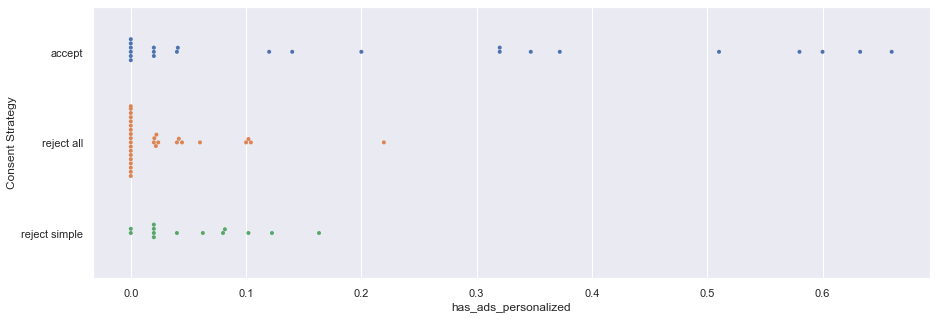

In [44]:
sns.swarmplot(data=aggs, x="has_ads_personalized", y="Consent Strategy", size=4)

C:\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


TypeError: Legend.__init__() got an unexpected keyword argument 'size'

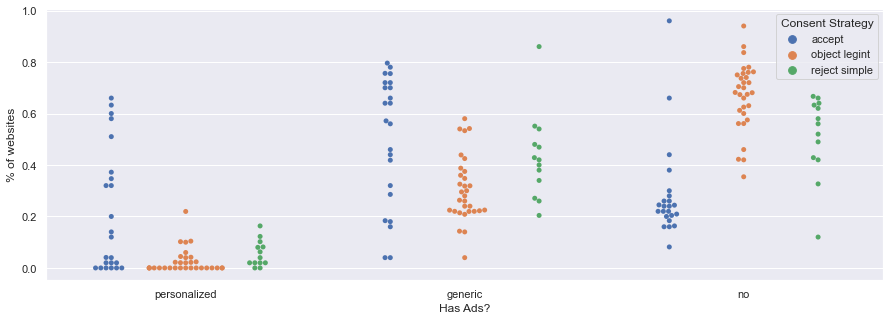

In [46]:
aggs_long = aggs.reset_index().melt(["ID", "Consent Strategy", "location"], value_vars=["has_ads_personalized", "has_ads_generic", "has_ads_no"])
aggs_long["variable"] = aggs_long["variable"].astype("category").cat.reorder_categories(["has_ads_personalized","has_ads_generic","has_ads_no"])
aggs_long["Consent Strategy"] = aggs_long["Consent Strategy"].astype("category").cat.reorder_categories(["accept", "reject simple", "reject all"])
aggs_long = aggs_long.rename(columns={"variable":"Has Ads?", "value": "% of websites"})
aggs_long["Has Ads?"] = aggs_long["Has Ads?"].str.replace("has_ads_","")
aggs_long["Consent Strategy"] = aggs_long["Consent Strategy"].str.replace("reject all","object legint")

sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.swarmplot(
    data=aggs_long,
    y="% of websites", hue="Consent Strategy", x="Has Ads?", dodge=True,, size=3
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
aggs_long

C:\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


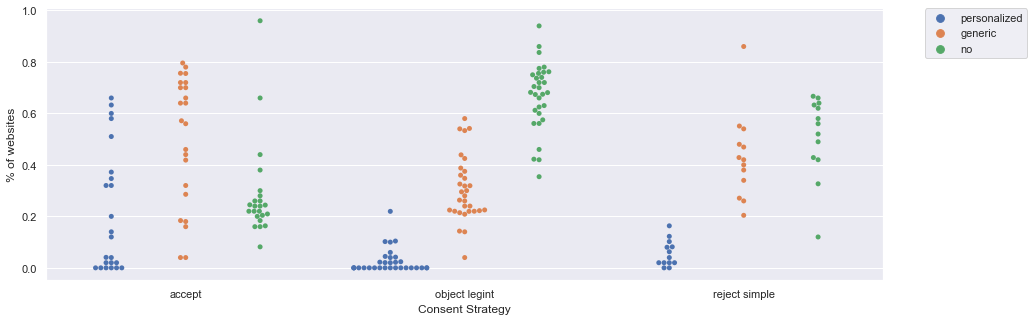

In [21]:
ax = sns.swarmplot(
    data=aggs_long,
    y="% of websites", hue="Has Ads?", x="Consent Strategy", dodge=True,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='% of websites', ylabel='Consent Strategy'>

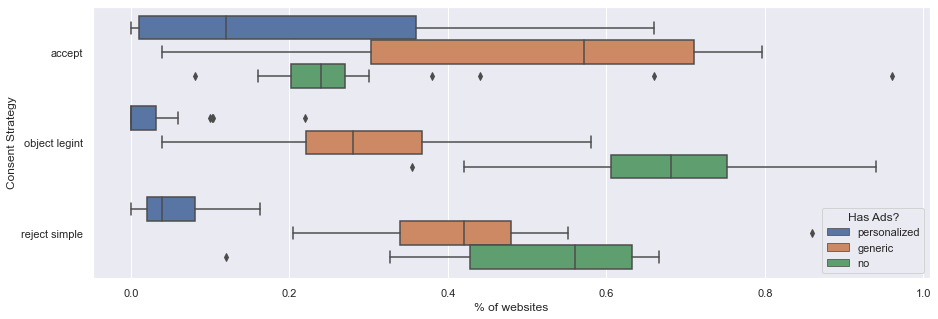

In [22]:
sns.boxplot(
    data=aggs_long,
    x="% of websites", y="Consent Strategy", hue="Has Ads?"
)

In [23]:
subsets = {
    "full": aggs_long,
    "nov21": aggs_long[(aggs_long.location == "in class") | (aggs_long.location == "from home")],
    "class1": aggs_long[aggs_long.location == "in class"],
    "home1": aggs_long[aggs_long.location == "from home"],
    "home2": aggs_long[aggs_long.location == "from home (repeated)"],
}

for sname, subset in subsets.items():
    with open(rf"barplots-{sname}.tex", "w") as f:
        for strat, rows in subset.groupby("Consent Strategy"):
            offset_x = 0
            rows = rows.pivot("ID", "Has Ads?", "% of websites")[["no", "generic", "personalized"]]

            #rows["sort_by"] = rows["generic"] + 3 * rows["personalized"]
            #rows = rows.sort_values(["sort_by"], ascending=False)
            #rows.drop(columns=["sort_by"])

            if strat == "accept":
                rows = rows.sort_values(["personalized", "generic", "no"], ascending=False)
            else:
                rows = rows.sort_values(["no", "generic", "personalized"], ascending=True)
            width = 1 / len(rows)
            group = strat.title().replace(" ","")
            print(r"\newcommand{\len%s}{%d}" % (group, len(rows)), file=f)

            for x in ["no", "generic", "personalized"]:
                print(r"\newcommand{\share%s%sAds}{%f}" % (group, x.title(), rows[x].mean()), file=f)

            print(r"\newcommand{\data%s}{" % group, file=f)
            for i, row in rows.iterrows():
                offset_y = 0
                for typ in ["no", "generic", "personalized"]:
                    val = row[typ]
                    if val > 0:
                        print(
                            r"    \path[fill=%s-color] (%.4f,%.4f) rectangle (%.4f,%.4f);" % (f"{typ: >12}", offset_x, offset_y,offset_x + width,offset_y + val),
                            file=f
                        )
                    offset_y += val
                offset_x += width
                #print(share[share["Has Ads?"] == "personalized"]["% of websites"])
            print("}", file=f)


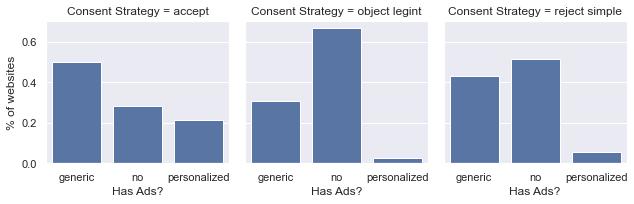

In [24]:
aggs_means = aggs_long.groupby(["Consent Strategy", "Has Ads?"])["% of websites"].mean().reset_index()
g = sns.FacetGrid(aggs_means, col="Consent Strategy", margin_titles=True, despine=False)
g.map_dataframe(sns.barplot, "Has Ads?", "% of websites")

plt.savefig('C:/Users/user/git/cookies/thesis/placeholders/admeasure-results.pdf')

In [25]:
aggs_long.groupby(["Consent Strategy", "Has Ads?"])["% of websites"].mean().reset_index()

,Consent Strategy,Has Ads?,% of websites
0,accept,generic,0.501154
1,accept,no,0.283946
2,accept,personalized,0.214900
3,object legint,generic,0.304769
4,object legint,no,0.668779
5,object legint,personalized,0.026452
6,reject simple,generic,0.431069
7,reject simple,no,0.512632
8,reject simple,personalized,0.056299


In [26]:
aggs_long
#g = sns.FacetGrid(aggs_long, col="Consent Strategy", margin_titles=True, despine=False)
#g.map_dataframe(sns.swarmplot, "Has Ads?", "% of websites")
aggs_long

,ID,Consent Strategy,location,Has Ads?,% of websites
0,1,accept,in class,personalized,0.372093
1,2,object legint,in class,personalized,0.000000
2,3,accept,in class,personalized,0.600000
3,4,object legint,in class,personalized,0.000000
4,5,accept,in class,personalized,0.040000
...,...,...,...,...,...
196,63,reject simple,from home (repeated),no,0.666667
197,64,reject simple,from home (repeated),no,0.326531
198,65,reject simple,from home (repeated),no,0.632653
199,66,reject simple,from home (repeated),no,0.660000


{'color': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)}
{'color': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)}
{'color': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)}


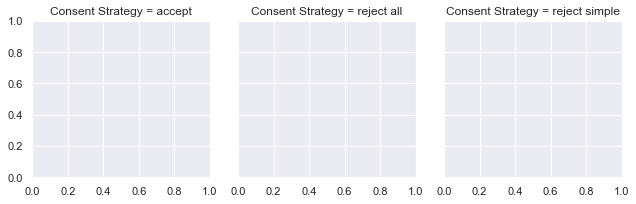

In [27]:
g = sns.FacetGrid(aggs, col="Consent Strategy", margin_titles=True, despine=False)
g.map_dataframe(lambda data, **kws: print(kws))


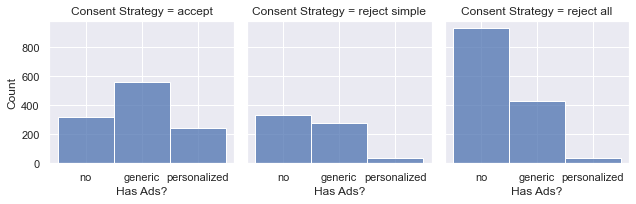

In [28]:
g = sns.FacetGrid(df, col="Consent Strategy", margin_titles=True, despine=False)
g.map_dataframe(sns.histplot, "Has Ads?")

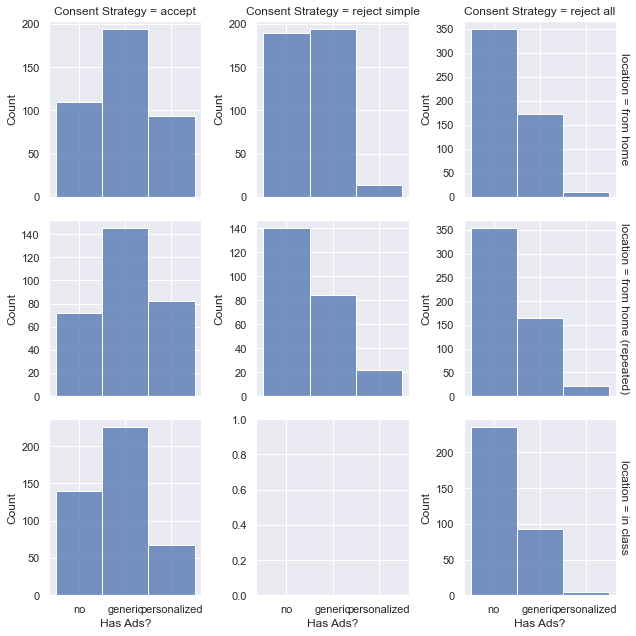

In [29]:
g = sns.FacetGrid(df, col="Consent Strategy", row="location", margin_titles=True, despine=False, sharey=False)
g.map_dataframe(sns.histplot, "Has Ads?")

In [30]:
#sns.catplot(x="Has Ads?", col="Consent Strategy", hue="Browser Profile", data=df, kind="count")